In [20]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
import sys
import pandas as pd
import seaborn as sns
import xarray as xr

sys.path.append('/home/ryuho/anaconda3/envs/smrai_env')
from esn_dts_openloop import ESN, Tikhonov

In [43]:
#REPPU otuputs
#path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Data/pbig5min.dat'
path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/wbig5min.dat'

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

In [44]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])
mhd_data

,start,end,total_days
0,2021/05/10,2021/05/14,5
1,2021/05/31,2021/06/03,4
2,2021/07/26,2021/07/29,4
3,2021/09/09,2021/09/12,4
4,2021/10/11,2021/10/14,4
5,2021/11/01,2021/11/06,6
6,2021/11/25,2021/11/29,5
7,2022/01/30,2022/02/03,5
8,2022/03/11,2022/03/15,5
9,2022/03/28,2022/04/01,5


In [45]:
# Reshape the array to have dimensions (days, time (5-min intervals), lat, lon)
#288 will become 1440 at 1-min resolution in SMRAI v3.0
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'conductivity': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['conductivity'].attrs['units'] = 'S/m'
ds

<xarray.Dataset>
Dimensions:       (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt            (dt) datetime64[ns] 2021-05-10 ... 2022-07-31T23:55:00
  * lat           (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon           (lon) float64 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    conductivity  (dt, lat, lon) float32 1.517 1.517 1.517 ... 5.178 5.173 5.166

In [5]:
#open the omni data and merge it with the REPPU data
omni_mhd_path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/OMNI/'

omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.dropna()

#convert the dataframe to an xarray dataset
omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')
reppu_omni_ds.sortby('dt')
reppu_omni_ds

<xarray.Dataset>
Dimensions:         (dt: 42158, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2021-05-10 ... 2022-07-31T23:55:00
  * lat             (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon             (lon) float64 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    conductivity    (dt, lat, lon) float32 1.517 1.517 1.517 ... 5.173 5.166
    BY_GSE          (dt) float64 4.72 4.35 4.61 4.65 ... -9.29 -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 6.24 6.55 6.56 6.89 ... -0.53 -0.74 -4.03 -4.71
    flow_speed      (dt) float64 344.0 344.0 345.0 344.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 12.11 11.44 12.65 12.63 ... 7.12 8.03 7.08 6.84
    tilt_angle      (dt) float64 0.253 0.2497 0.2465 ... 0.2778 0.2744 0.271

In [6]:
# Define the slice ranges for train and test data
train_slice = slice(0, 36576)  #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None)  # 9216 / 24 / 12 = 32 days = 20% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

In [7]:
#training
X_train = ds_train.drop_vars('conductivity').to_array().values.T #drop conductivity and keep the rest
y_train = ds_train['conductivity'].values
y_train = y_train.reshape(-1, 30*80) #flatten lat & lon

#testing
X_test = ds_test.drop_vars('conductivity').to_array().values.T #drop conductivity and keep the rest
y_test = ds_test['conductivity'].values
y_test = y_test.reshape(-1, 30*80) #flatten lat & lon

In [8]:
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 250 #number of reservoir neurons

#built, optimize and train model
model = ESN(N_u = input_dim, N_y = output_dim, N_x=reservoir_size, density=0.1, input_scale=0.1, rho=0.99)
optimizer = Tikhonov(N_u = input_dim, N_x = reservoir_size, N_y = output_dim, beta=1e-3)
model.train(X_train, y_train, optimizer)

array([[  59.17415047, -401.45096267,  268.85373093, ..., -573.47927344,
        -652.62033026,  792.45032891],
       [  57.25215   , -401.58119387,  267.8143115 , ..., -573.25943367,
        -651.452687  ,  789.86623521],
       [  57.3100277 , -401.79994819,  267.486732  , ..., -573.85446444,
        -654.04199479,  791.32642952],
       ...,
       [  64.45981969, -393.85660783,  271.32278816, ..., -572.88814219,
        -642.60283537,  774.65197025],
       [  64.94139628, -394.19668174,  272.00526602, ..., -573.68505293,
        -642.05097345,  774.81321321],
       [  64.78020013, -392.35193225,  270.91919597, ..., -571.79638716,
        -640.3147514 ,  772.04195986]])

In [9]:
y_pred = model.predict(X_test) #predict the test data
y_pred = y_pred.reshape(-1, 30, 80) #reshape the prediction to lat, lon
y_pred.shape

(5582, 30, 80)

In [10]:
# Create xarray Dataset
ds_pred = xr.Dataset({'conductivity': (['dt', 'lat', 'lon'], y_pred)},
                coords={'dt': ds_test['dt'], 'lat': ds_test['lat'], 'lon': ds_test['lon']})

# Add conductivity and units
ds_pred['conductivity'].attrs['units'] = 'S/m'
ds_pred

#add other variables to the prediction dataset
ds_pred = ds_pred.merge(ds_test.drop_vars('conductivity'))
ds_pred

<xarray.Dataset>
Dimensions:         (dt: 5582, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2022-07-11T15:05:00 ... 2022-07-31T23...
  * lat             (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon             (lon) float64 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    conductivity    (dt, lat, lon) float64 1.517 1.517 1.517 ... 4.721 4.722
    BY_GSE          (dt) float64 7.96 8.2 8.13 8.94 ... -9.29 -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 -3.35 -2.99 -2.57 -2.31 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 340.0 341.0 337.0 336.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 9.32 9.77 10.02 9.5 ... 7.12 8.03 7.08 6.84
    tilt_angle      (dt) float64 0.5268 0.5285 0.5301 ... 0.2778 0.2744 0.271

<>:19: SyntaxWarning: invalid escape sequence '\M'
<>:19: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipykernel_91789/437681414.py:19: SyntaxWarning: invalid escape sequence '\M'
  plt.annotate(f'RMSE = {rmse:.2f} s\M', xy=(0.77, 0.1), xycoords='axes fraction')


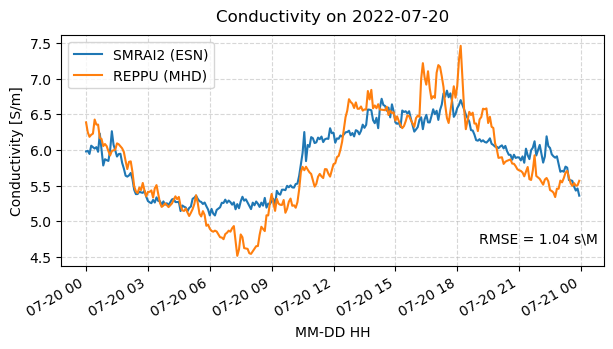

In [11]:
#plot potential on 2022-07-11, integrtaed over lat and lon

#2022-07-14 is worst
#2022-07-15 is worst

#2022-07-22 is good
#2022-07-23 is good
#2022-07-28 is good
#2022-07-30 is good

#2022-07-24 is best
#2022-07-29 is best
date = '2022-07-20'
fig, ax = plt.subplots(figsize=(7, 3))
ds_pred['conductivity'].sel(dt=date).mean(['lat', 'lon']).plot(label='SMRAI2 (ESN)')
ds_test['conductivity'].sel(dt=date).mean(['lat', 'lon']).plot(label='REPPU (MHD)')

rmse = np.sqrt(np.mean((ds_pred['conductivity'].sel(dt=date).values - ds_test['conductivity'].sel(dt=date).values)**2))
plt.annotate(f'RMSE = {rmse:.2f} s\M', xy=(0.77, 0.1), xycoords='axes fraction')

plt.legend()
plt.title(f'Conductivity on {date}', pad=10)
plt.xlabel('MM-DD HH')
phi = r'$\phi$'
plt.ylabel(f'Conductivity [S/m]')
plt.grid(True, linestyle='--', alpha=0.5)


<>:16: SyntaxWarning: invalid escape sequence '\M'
<>:16: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipykernel_91789/357255934.py:16: SyntaxWarning: invalid escape sequence '\M'
  plt.annotate(f'RMSE = {rmse:.2f} s\M', xy=(0.02, 0.9), xycoords='axes fraction')


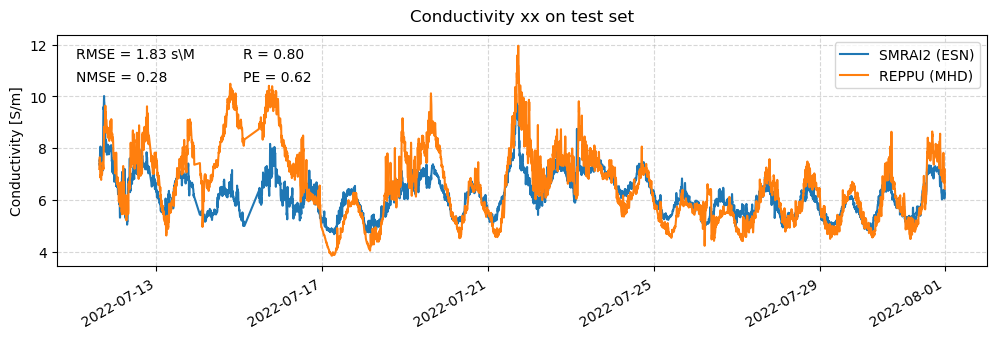

In [12]:
fig, ax = plt.subplots(figsize=(12, 3))
ds_pred['conductivity'].mean(['lat', 'lon']).plot(label='SMRAI2 (ESN)')
ds_test['conductivity'].mean(['lat', 'lon']).plot(label='REPPU (MHD)')

rmse = np.sqrt(np.mean((ds_pred['conductivity'].values - ds_test['conductivity'].values)**2))
nrmse = rmse / np.mean(ds_test['conductivity'].values)
R = np.corrcoef(ds_pred['conductivity'].values.flatten(), ds_test['conductivity'].values.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill  
PE = skill(ds_pred['conductivity'].values, ds_test['conductivity'].values)

plt.annotate(f'RMSE = {rmse:.2f} s\M', xy=(0.02, 0.9), xycoords='axes fraction')
plt.annotate(f'NMSE = {nrmse:.2f}', xy=(0.02, 0.8), xycoords='axes fraction')
plt.annotate(f'R = {R:.2f}', xy=(0.2, 0.9), xycoords='axes fraction')
plt.annotate(f'PE = {PE:.2f}', xy=(0.2, 0.8), xycoords='axes fraction')

plt.legend()
plt.title(f'Conductivity xx on test set', pad=10)
plt.xlabel(' ')
phi = r'$\phi$'
plt.ylabel(f'Conductivity [S/m]')
plt.grid(True, linestyle='--', alpha=0.5)

In [13]:
#loop through all dates in the test and pred dataset and calculate the RMSE then put into a df
err_list = []
for date in ds_test['dt']:
    rmse = np.sqrt(np.mean((ds_pred['conductivity'].sel(dt=date).values - ds_test['conductivity'].sel(dt=date).values)**2))
    nmse = rmse / np.std(ds_test['conductivity'].sel(dt=date).values)
    err_list.append([rmse, nmse])

err_df = pd.DataFrame(err_list, columns=['RMSE', 'NRMSE'])
err_df['dt'] = ds_test['dt']
err_df['date'] = err_df['dt'].dt.date
err_df['hr'] = err_df['dt'].dt.hour
err_df

,RMSE,NRMSE,dt,date,hr
0,0.902405,0.375691,2022-07-11 15:05:00,2022-07-11,15
1,0.935807,0.384370,2022-07-11 15:10:00,2022-07-11,15
2,1.029495,0.402195,2022-07-11 15:15:00,2022-07-11,15
3,1.129620,0.428420,2022-07-11 15:20:00,2022-07-11,15
4,1.063439,0.402844,2022-07-11 15:25:00,2022-07-11,15
...,...,...,...,...,...
5577,1.361587,0.533346,2022-07-31 23:35:00,2022-07-31,23
5578,1.945094,0.666479,2022-07-31 23:40:00,2022-07-31,23
5579,1.856691,0.661236,2022-07-31 23:45:00,2022-07-31,23
5580,1.355876,0.518116,2022-07-31 23:50:00,2022-07-31,23


In [14]:
err_df.groupby('date').mean().sort_values(by='NRMSE', ascending=True)

,RMSE,NRMSE,dt,hr
date,,,,
2022-07-24,1.059942,0.396920,2022-07-24 11:57:06.923076864,11.493007
2022-07-23,1.531067,0.467252,2022-07-23 12:18:45.000000000,11.855072
2022-07-29,0.923679,0.491980,2022-07-29 11:59:08.936169984,11.524823
2022-07-13,1.414737,0.518452,2022-07-13 10:48:32.790697728,10.348837
2022-07-20,1.009582,0.519978,2022-07-20 11:50:51.063829760,11.390071
2022-07-30,1.131690,0.528605,2022-07-30 11:58:31.267605760,11.517606
2022-07-28,1.139439,0.529146,2022-07-28 11:58:26.451612928,11.516129
2022-07-22,1.662577,0.556380,2022-07-22 12:00:37.894736640,11.550877
2022-07-11,1.642935,0.569285,2022-07-11 19:31:56.037735936,19.066038


/home/ryuho/anaconda3/envs/smrai_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ryuho/anaconda3/envs/smrai_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'RMSE [S/m]')

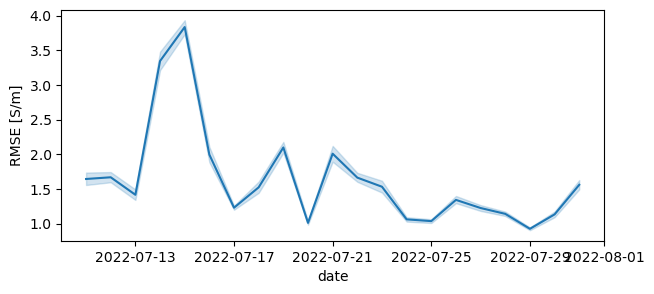

In [15]:
#plot the RMSE
fig, ax = plt.subplots(figsize=(7, 3))
sns.lineplot(data=err_df, x='date', y='RMSE', ax=ax)
plt.ylabel('RMSE [S/m]')
#plt.xticks(np.arange(0, 25, 3))
#plt.xlabel('UTC')

In [16]:
#print unique dates from ds_pred dt
dates = ds_pred['dt'].dt.strftime('%Y-%m-%d').values
unique_dates = np.unique(dates)
unique_dates

array(['2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
       '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
       '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
       '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26',
       '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30',
       '2022-07-31'], dtype=object)

In [17]:
date = '2022-07-31'

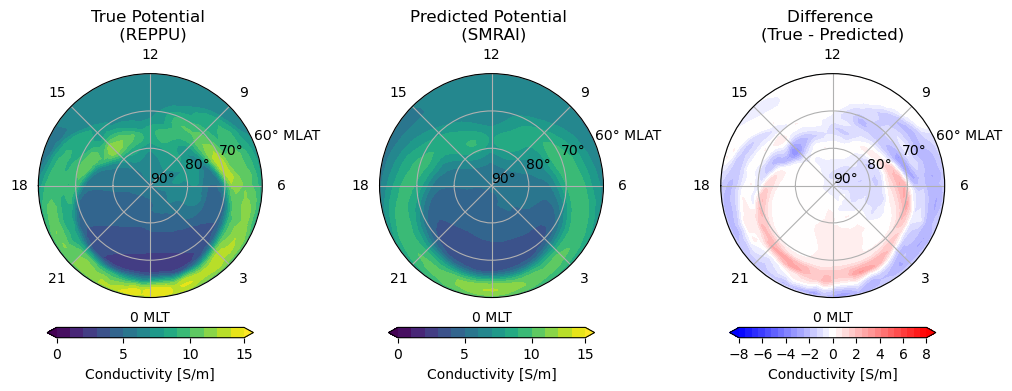

In [18]:
# Define the date
date = "2022-07-20"

# Extract true and predicted values
cond_true = ds_test['conductivity'].sel(dt=date).values[0]
cond_pred = ds_pred['conductivity'].sel(dt=date).values[0]

# Calculate the difference
diff = cond_true - cond_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, cond_true, levels=np.arange(0, 15, 1), cmap='viridis', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 16, 5), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, cond_pred, levels=np.arange(0, 15, 1), cmap='viridis', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 16, 5), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-8, 8, 30), cmap='bwr', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[2].set_title('Difference \n(True - Predicted)')
plt.colorbar(c_diff, ax=axs[2], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(-8, 9, 2), orientation='horizontal')

plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()


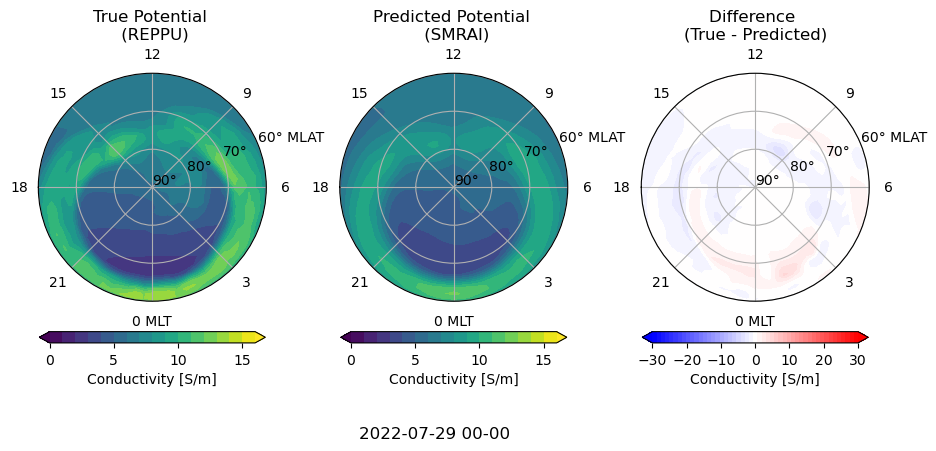

In [19]:

# Select the date
date = "2022-07-29"

# Extract times from dt dimension info
times = ds_test.sel(dt=date)['dt'].values

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .28
pad = 0.13
phi = r"$\mathrm{\phi}$"

# Loop through each time step
for i, time in enumerate(times):
    # Extract true and predicted values for the current time
    pot_true = ds_test['conductivity'].sel(dt=date).values[i]
    pot_pred = ds_pred['conductivity'].sel(dt=date).values[i]

    # Calculate the difference
    diff = pot_true - pot_pred

    # Set up the plot
    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

    # Define common parameters
    theta = np.linspace(0, 360, 80) - 90
    theta_rad = theta / 360 * 2 * np.pi
    r = 90 - np.linspace(53.1, 89.7, 30)
    shrink = .3

    # Plot true values
    c_true = axs[0].contourf(theta_rad, r, cond_true, levels=np.arange(0, 17, 1), cmap='viridis', extend='both')
    axs[0].set_ylim([0, 30])
    axs[0].set_yticks([0, 10, 20, 30])
    axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[0].set_xlim([-np.pi, np.pi])
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[0].set_title(f'True Potential \n (REPPU)')
    plt.colorbar(c_true, ax=axs[0], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 17, 5), orientation='horizontal')

    # Plot predicted values
    c_pred = axs[1].contourf(theta_rad, r, cond_pred, levels=np.arange(0, 17, 1), cmap='viridis', extend='both')
    axs[1].set_ylim([0, 30])
    axs[1].set_yticks([0, 10, 20, 30])
    axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[1].set_xlim([-np.pi, np.pi])
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[1].set_title(f'Predicted Potential \n (SMRAI)')
    plt.colorbar(c_pred, ax=axs[1], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 17, 5), orientation='horizontal')

    # Plot difference
    c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='bwr', extend='both')
    axs[2].set_ylim([0, 30])
    axs[2].set_yticks([0, 10, 20, 30])
    axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[2].set_xlim([-np.pi, np.pi])
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[2].set_title('Difference \n(True - Predicted)')
    plt.colorbar(c_diff, ax=axs[2], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    plt.tight_layout()

    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H-%M')

    plt.annotate(f'{str_time}', xy=(-1.24, -0.6), xycoords='axes fraction', fontsize=12)
    plt.subplots_adjust(wspace=-0.6) 

    # Save the figure with the timestamp in the title
    #export_path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/Research/JSPS/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/'
    #plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/potential_plot_{str_time}.png', dpi=300, bbox_inches='tight')
    
    # Close the figure to free up memory
    #plt.close(fig)

    break